In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.spatial import distance_matrix

In [2]:
import gust
import itertools

In [3]:
dataset_name = 'cora_ml'
dataset = gust.datasets.load_dataset(dataset_name)

In [4]:
graph = dataset.standardize(
        make_unweighted = True, make_undirected = True,
        no_self_loops = True, select_lcc = True
    )

In [5]:
graph.class_names

array(['Artificial_Intelligence/Machine_Learning/Case-Based',
       'Artificial_Intelligence/Machine_Learning/Theory',
       'Artificial_Intelligence/Machine_Learning/Genetic_Algorithms',
       'Artificial_Intelligence/Machine_Learning/Probabilistic_Methods',
       'Artificial_Intelligence/Machine_Learning/Neural_Networks',
       'Artificial_Intelligence/Machine_Learning/Rule_Learning',
       'Artificial_Intelligence/Machine_Learning/Reinforcement_Learning'],
      dtype='<U63')

In [6]:
# Count intra-cluster edges
num_intra_cluster_edges = np.zeros((len(np.unique(graph.labels)), len(np.unique(graph.labels))), dtype=int)
for label_i in range(len(graph.class_names)):
    for label_j in range(len(graph.class_names)):
        num_intra_cluster_edges[label_i, label_j] = graph.adj_matrix[graph.labels == label_i][:, graph.labels == label_j].nnz


In [7]:
if dataset_name == 'cora_ml':
    class_names = np.array([cn.split('/')[-1] for cn in graph.class_names])
else:
    class_names = graph.class_names
#g = sns.JointGrid(data=num_intra_cluster_edges)

<AxesSubplot:>

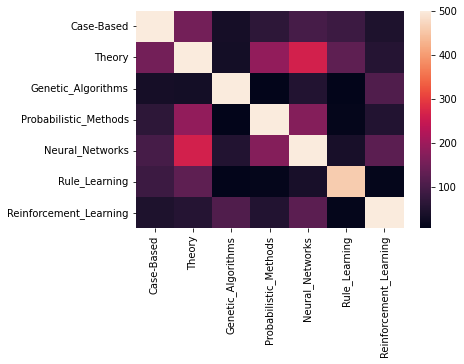

In [8]:

sns.heatmap(pd.DataFrame(num_intra_cluster_edges, class_names, class_names), vmax=500)

In [9]:
# Get all partitions of labels into two sets (2^(num_lables - 1) - 1, as we exclude empty partions)
partitions = [mask for mask in [np.array([False] + list(m)) for m in itertools.product([True, False], repeat=len(graph.class_names) - 1)] if mask.sum() > 0]

In [11]:
# Calculate the edge density within a partition and between partitions
partition_inter_densities = []
for mask in partitions:
    # Treat the two partitions as classes
    edges_inter = num_intra_cluster_edges[mask][:, mask].sum() + num_intra_cluster_edges[~mask][:, ~mask].sum()
    density_inter = edges_inter / num_intra_cluster_edges.sum()
    
    # Compute densities for each partition
    density_inter_first = num_intra_cluster_edges[mask][:, mask].sum() / num_intra_cluster_edges[mask].sum()
    density_inter_second = num_intra_cluster_edges[~mask][:, ~mask].sum() / num_intra_cluster_edges[~mask].sum()
    
    
    partition_inter_densities.append({
        'Average inter partition density' : density_inter,
        'Intra partition density first' : density_inter_first,
        'Intra partition density second' : density_inter_second,
        'Min partition density both' : min(density_inter_first, density_inter_second),
        'First' : tuple(class_names[mask]), 
        'Second' : tuple(class_names[~mask]),
    })
    
df_partition_densities = pd.DataFrame(partition_inter_densities)


In [12]:
df_partition_densities.sort_values(by='Min partition density both', ascending=False)

,Average inter partition density,Intra partition density first,Intra partition density second,Min partition density both,First,Second
46,0.947626,0.917975,0.961531,0.917975,"(Genetic_Algorithms, Reinforcement_Learning)","(Case-Based, Theory, Probabilistic_Methods, Ne..."
47,0.969803,0.901673,0.982163,0.901673,"(Genetic_Algorithms,)","(Case-Based, Theory, Probabilistic_Methods, Ne..."
38,0.900764,0.893748,0.906911,0.893748,"(Genetic_Algorithms, Probabilistic_Methods, Re...","(Case-Based, Theory, Neural_Networks, Rule_Lea..."
19,0.898760,0.903511,0.893516,0.893516,"(Theory, Probabilistic_Methods, Neural_Networks)","(Case-Based, Genetic_Algorithms, Rule_Learning..."
17,0.907906,0.919293,0.892779,0.892779,"(Theory, Probabilistic_Methods, Neural_Network...","(Case-Based, Genetic_Algorithms, Reinforcement..."
...,...,...,...,...,...,...
53,0.906653,0.758978,0.942118,0.758978,"(Probabilistic_Methods, Rule_Learning)","(Case-Based, Theory, Genetic_Algorithms, Neura..."
29,0.894750,0.755814,0.932918,0.755814,"(Theory, Rule_Learning)","(Case-Based, Genetic_Algorithms, Probabilistic..."
0,0.940233,0.966416,0.728823,0.728823,"(Theory, Genetic_Algorithms, Probabilistic_Met...","(Case-Based,)"
31,0.897632,0.698190,0.938363,0.698190,"(Theory,)","(Case-Based, Genetic_Algorithms, Probabilistic..."


# Attributes

## Pairwise distances between class centroids

In [13]:
df_attributes = pd.DataFrame(graph.attr_matrix.toarray(), columns=graph.attr_names)
df_attributes['class_label'] = [graph.class_names[i].split('/')[-1] for i in graph.labels]
mean_attributes_df = df_attributes.groupby('class_label').mean()

In [14]:
mean_attributes = mean_attributes_df.to_numpy()
distances = np.linalg.norm(mean_attributes[:, None, :] - mean_attributes[None, :, :], axis=-1)
distances

array([[0.        , 0.25639415, 0.2301863 , 0.24202158, 0.25899678,
        0.24643561, 0.23057562],
       [0.25639415, 0.        , 0.21265274, 0.24030423, 0.25233054,
        0.26040214, 0.23494913],
       [0.2301863 , 0.21265274, 0.        , 0.1725276 , 0.22518703,
        0.23383795, 0.1820593 ],
       [0.24202158, 0.24030423, 0.1725276 , 0.        , 0.25102082,
        0.25383452, 0.19727056],
       [0.25899678, 0.25233054, 0.22518703, 0.25102082, 0.        ,
        0.26459253, 0.22848532],
       [0.24643561, 0.26040214, 0.23383795, 0.25383452, 0.26459253,
        0.        , 0.20689121],
       [0.23057562, 0.23494913, 0.1820593 , 0.19727056, 0.22848532,
        0.20689121, 0.        ]], dtype=float32)

<AxesSubplot:xlabel='class_label', ylabel='class_label'>

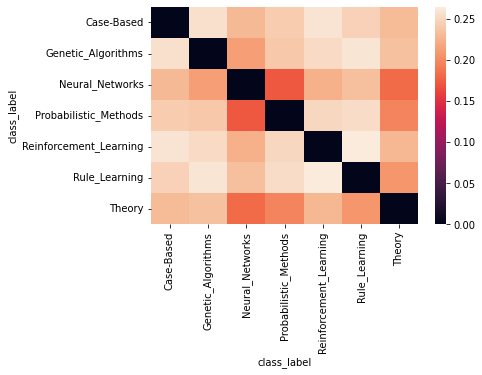

In [15]:

sns.heatmap(pd.DataFrame(distances, mean_attributes_df.index, mean_attributes_df.index), )

## Distribution of distances from class centroids (variance within class)

In [16]:
mean_attributes = np.array([mean_attributes_df.loc[cn] for cn in class_names]) # Has the same order as class names

<AxesSubplot:xlabel='difference', ylabel='label'>

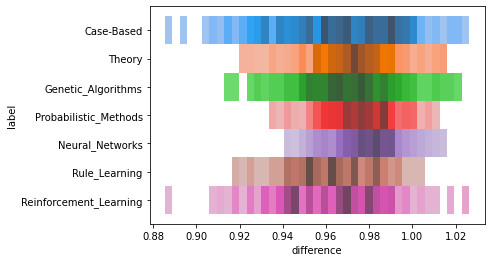

In [17]:

df_attribute_differences = pd.DataFrame({'difference' : np.linalg.norm(graph.attr_matrix.toarray() - mean_attributes[graph.labels], axis=-1), 'label' : class_names[graph.labels]},)
sns.histplot(df_attribute_differences, x='difference', y='label', hue='label', legend=False,
                     common_norm=False,)

## Average pairwise feature distances within community pairs

In [18]:
from sklearn.metrics import pairwise_distances
attr_mat = graph.attr_matrix.toarray()
pairwise_distances = pairwise_distances(graph.attr_matrix, graph.attr_matrix, n_jobs=-1)

In [19]:
avg_distances_per_class = np.zeros((len(np.unique(graph.labels)), len(np.unique(graph.labels))))
for label_i in range(len(np.unique(graph.labels))):
    for label_j in range(len(np.unique(graph.labels))):
        avg_distances_per_class[label_i, label_j] = pairwise_distances[graph.labels == label_i][:, graph.labels == label_j].mean()

<AxesSubplot:>

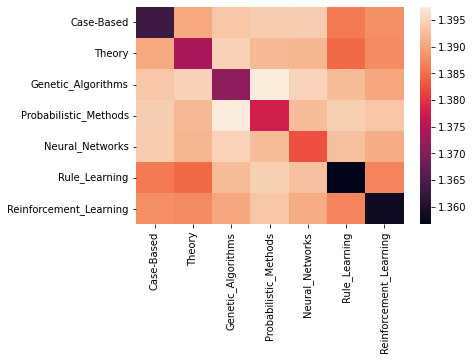

In [20]:
sns.heatmap(pd.DataFrame(avg_distances_per_class, class_names, class_names))

## Plot of attributes with high values per class

In [21]:
mean_attributes_df

,000,10,100,11,12,13,14,15,16,17,...,written,wrong,www,years,yield,yielding,yields,york,young,zero
class_label,,,,,,,,,,,,,,,,,,,,,
Case-Based,0.000974,0.000828,0.000277,0.000858,0.002903,0.001606,0.001053,0.000397,0.000407,0.001339,...,0.001310,0.001199,0.001456,0.001554,0.000605,0.000526,0.001788,0.000000,0.000280,0.000401
Genetic_Algorithms,0.000282,0.003344,0.000536,0.002754,0.000666,0.001390,0.000902,0.000535,0.003219,0.000000,...,0.001365,0.000000,0.001606,0.003249,0.001173,0.000000,0.000503,0.000636,0.000308,0.001504
Neural_Networks,0.001174,0.003429,0.001659,0.002187,0.002524,0.001928,0.002427,0.002012,0.001340,0.000607,...,0.001361,0.000169,0.001408,0.001261,0.002453,0.000327,0.002628,0.000708,0.000712,0.002646
Probabilistic_Methods,0.001001,0.002395,0.000000,0.000935,0.001407,0.000000,0.000817,0.000871,0.000382,0.001017,...,0.000974,0.000249,0.001257,0.003903,0.001856,0.001532,0.002004,0.000848,0.000651,0.001999
Reinforcement_Learning,0.001005,0.001487,0.000000,0.002558,0.000000,0.000825,0.000000,0.000388,0.000511,0.001904,...,0.001052,0.000977,0.000000,0.001445,0.001607,0.000000,0.001638,0.000000,0.000321,0.002310
Rule_Learning,0.001143,0.000907,0.000000,0.002730,0.000000,0.001502,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000922,0.002298,0.000000,0.000000,0.001470,0.000000,0.000639,0.000000
Theory,0.000228,0.001654,0.000000,0.001576,0.001394,0.000260,0.000849,0.001021,0.001452,0.000678,...,0.001845,0.000611,0.001562,0.000933,0.002396,0.000910,0.002323,0.001236,0.000169,0.003521


### Distribution of mean values of all features and classes (to determine thresholds for "frequent attributes")

<AxesSubplot:ylabel='Count'>

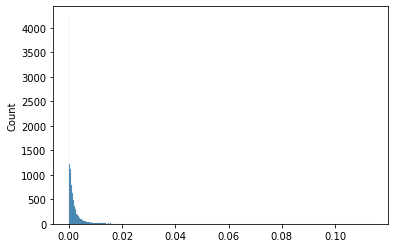

In [22]:
sns.histplot(mean_attributes_df.to_numpy().flatten())

<AxesSubplot:ylabel='class_label'>

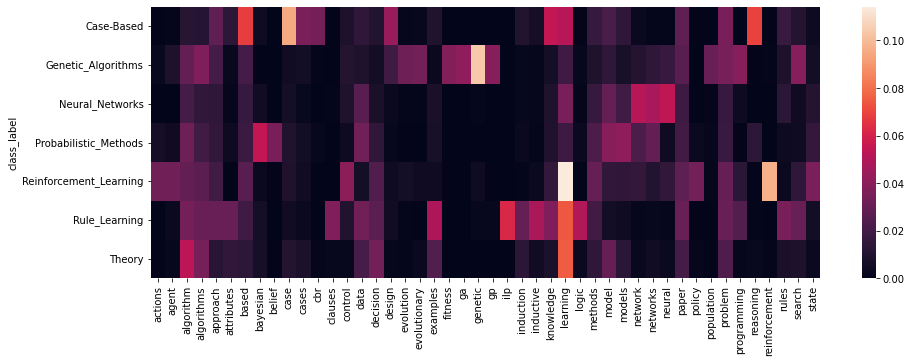

In [23]:
threshold = 0.03 # Attributes with a mean per class that is higher than that are considered "frequent"
columns_above_threshold = [c for c in mean_attributes_df.columns if (mean_attributes_df[c] >= threshold).any()]
plt.figure(figsize=(15, 5))
sns.heatmap(mean_attributes_df[columns_above_threshold])